In [36]:
!pwd

/Users/josephyusufov


In [171]:
import uuid
from pprint import pprint
import os
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

secrets = open('/Users/josephyusufov/kalshi/secrets.json')
secrets = json.load(secrets)

KALSHI_HOST = secrets['KALSHI_HOST']
KALSHI_USERNAME = secrets['KALSHI_USERNAME']
KASLHI_PASSWORD = secrets['KASLHI_PASSWORD']

url = KALSHI_HOST + '/login'
headers = {
    "accept": "application/json",
    "content-type": "application/json"
}
body = {
    "email": KALSHI_USERNAME,
    "password": KASLHI_PASSWORD
}
response = requests.post(url, headers=headers, json=body)
token = response.json()['token']

def getMarketHist(market):
    url = "https://trading-api.kalshi.com/trade-api/v2/markets/%s/history?&limit=1000" % (market)
    headers = {
        "accept": "application/json",
        "Authorization": "Bearer " + token
    }
    response = requests.get(url, headers=headers)
    res = response.json()
    cursor = res['cursor']
    df = pd.DataFrame(res['history'])
    while cursor:
        url = "https://trading-api.kalshi.com/trade-api/v2/markets/%s/history?&cursor=%s&limit=1000" % (market, cursor)
        headers = {
            "accept": "application/json",
            "Authorization": "Bearer " + token
        }
        response = requests.get(url, headers=headers)
        res = response.json()
        cursor = res['cursor']
        df = pd.concat([df, pd.DataFrame(res['history'])])
    df.set_index("ts", inplace=True)
    df['dt'] = pd.to_datetime(df.index, unit='s')
    df['no_price'] = (df['no_bid'] + df['no_ask']) / 2
    df['premium'] = 100 - df['no_ask'] - df['yes_price']
    df['buy'] = np.sign(df['premium']) > 0
    return df

        

# df = df.rename(columns={"yes_price": "INX-24APR10-B5112"})
# ser1 = pd.DataFrame({"INX-24APR10-B5137": getMarketHist("INX-24APR10-B5137", 10)['yes_price']})
# ser2 = pd.DataFrame({"INX-24APR10-B5187": getMarketHist("INX-24APR10-B5187", 10)['yes_price']})
# ser3 = pd.DataFrame({"INX-24APR10-B5212": getMarketHist("INX-24APR10-B5212", 10)['yes_price']})

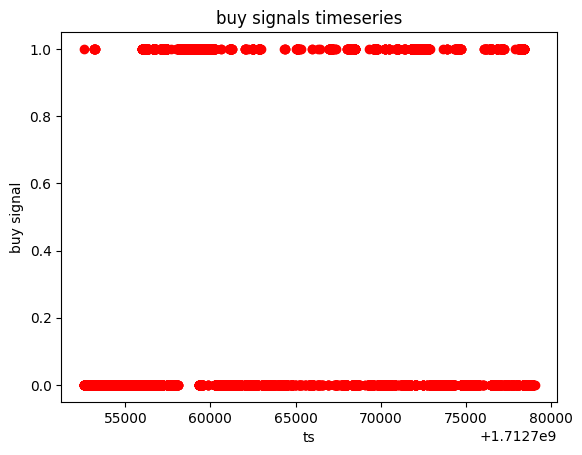

<Axes: xlabel='dt'>

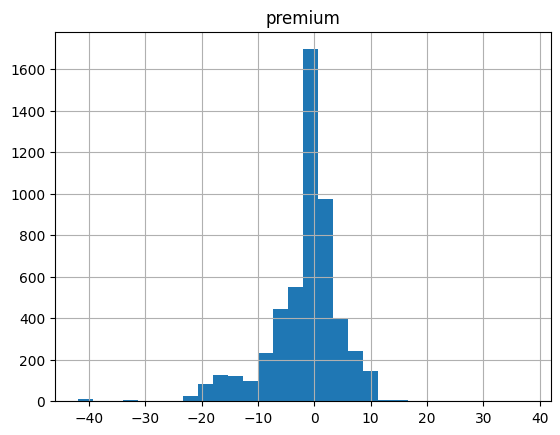

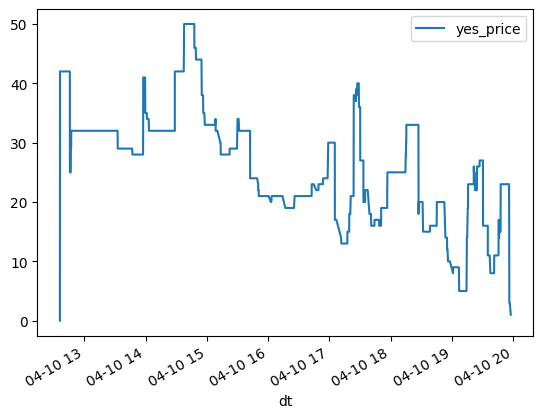

In [175]:
df = getMarketHist("INXU-24APR10-T5174.99")
df = df.loc[1712752200:1712782800]
df

plt.scatter(df.index.to_series(), df['buy'], color = 'red')
plt.title("buy signals timeseries")
plt.xlabel("ts")
plt.ylabel("buy signal")
plt.show()

df.hist(column="premium", bins=30)
df.plot(x="dt", y=["yes_price"])

count     2329.000000
mean        41.770717
std       1142.404716
min          0.000000
25%          1.000000
50%          2.000000
75%          8.000000
max      54006.000000
Name: diff, dtype: float64

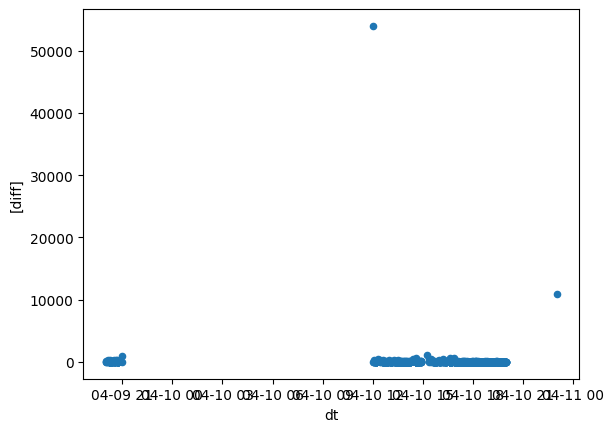

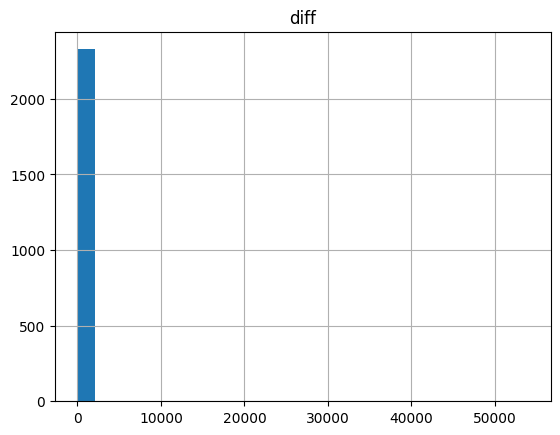

In [196]:
# df['diff'] = df.index.to_series().diff()
# df.plot(x="dt", y=['diff'], kind="scatter")
# df.hist(column='diff', bins=25)
# df['diff'].describe()
# df.index